In [1629]:
import cv2
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from scipy.signal import find_peaks
from skimage.feature import canny
import os
from itertools import combinations


In [1630]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [1631]:
def gamma_correction(image, gamma):
    # Normalize pixel values to the range [0, 1]
    normalized_image = image / 255.0
    
    # Apply gamma correction
    corrected_image = np.power(normalized_image, gamma)
    
    # Denormalize the corrected image to the original range [0, 255]
    corrected_image = (corrected_image * 255).astype(np.uint8)
    
    return corrected_image

In [1632]:
def is_high_brightness(image, threshold=200):

    # Calculate the average brightness
    average_brightness = np.mean(image)

    # Check if the average brightness is above the threshold
    return average_brightness > threshold

In [1633]:
def calculate_quadrilateral_area(vertices):
    n = len(vertices)
    area = 0.5 * abs(np.dot(vertices[:, 0], np.roll(vertices[:, 1], 1)) - np.dot(vertices[:, 1], np.roll(vertices[:, 0], 1)))
    return area

def find_max_parallelogram(points):
    max_area = 0
    max_parallelogram = []

    # Generate all possible combinations of 4 points
    point_combinations = list(combinations(points, 4))

    for combination in point_combinations:
        p1, p2, p3, p4 = combination
        area = calculate_quadrilateral_area([p1, p2, p3,p4])
        if area > max_area:
            max_area = area
            max_parallelogram = [p1, p2, p3, p4]

    return max_parallelogram

In [1634]:
def getRectangleEdges(contour):
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx_contour = cv2.approxPolyDP(contour, epsilon, True)
    # selected_vertices = approx_contour[:4]
    hull = cv2.convexHull(approx_contour)
    selected_vertices = find_max_parallelogram(hull)
    box = np.int0(selected_vertices)
    
    print(len(selected_vertices),len(box),hull)
    
    # Sort the vertices based on their position in the convex hull
    ordered_box = sorted(box, key=lambda x: (x[0][0], x[0][1]))
    if ordered_box[0][0][1] > ordered_box[1][0][1]:
        ordered_box[0], ordered_box[1] = ordered_box[1], ordered_box[0]
    if ordered_box[2][0][1] > ordered_box[3][0][1]:
        ordered_box[2], ordered_box[3] = ordered_box[3], ordered_box[2]
    if ordered_box[0][0][0] > ordered_box[3][0][0]:
        ordered_box[0], ordered_box[3] = ordered_box[3], ordered_box[0]
    if ordered_box[1][0][0] > ordered_box[2][0][0]:
        ordered_box[0], ordered_box[3] = ordered_box[3], ordered_box[0]
    
    top_left,top_right, bottom_right, bottom_left = ordered_box
    return [tuple(top_right[0]), tuple(bottom_left[0]), tuple(top_left[0]), tuple(bottom_right[0])]

In [1635]:
def doWork(imgPath):
    # read image
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    if is_high_brightness(img):
        gamma = 7
        # img = gamma_correction(img,gamma)
        img = cv2.equalizeHist(img)
    else:
        gamma = 0.889
        img = gamma_correction(img,gamma)

    # get histogram and find peaks
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256])
    peaks, _ = find_peaks(hist, distance=30,height=1000, prominence=100)

    # Plot the histogram and highlight the peaks
    # plt.plot(hist)
    # plt.plot(peaks, hist[peaks], 'ro')  # Mark peaks with red dots
    # plt.title('Image Histogram with Peaks')
    # plt.xlabel('Pixel Intensity')
    # plt.ylabel('Frequency')
    # plt.show()

    # segmentation
    binaryThreshold = (peaks[0]+peaks[1]) /2
    binary_image = 255 - cv2.threshold(img, binaryThreshold, 255, cv2.THRESH_BINARY)[1]

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = cv2.cvtColor(img.copy(),cv2.COLOR_GRAY2BGR)
    # contour_image = img.copy()
    largest_contour = max(contours, key=cv2.contourArea)
    # cv2.drawContours(contour_image, largest_contour, -1, (0, 255, 0), 2)
    rectangle = cv2.approxPolyDP(largest_contour, 0.04 * cv2.arcLength(largest_contour, True), True)
    rectangle = getRectangleEdges(rectangle)
    
    cv2.line(contour_image, rectangle[0], rectangle[0], (255, 0, 0), 2)
    cv2.line(contour_image, rectangle[0], rectangle[1], (255, 0, 0), 2)
    cv2.line(contour_image, rectangle[0], rectangle[2], (255, 0, 0), 2)
    cv2.line(contour_image, rectangle[0], rectangle[3], (255, 0, 0), 2)
    cv2.line(contour_image, rectangle[1], rectangle[0], (0, 255, 0), 2)
    cv2.line(contour_image, rectangle[1], rectangle[1], (0, 255, 0), 2)
    cv2.line(contour_image, rectangle[1], rectangle[2], (0, 255, 0), 2)
    cv2.line(contour_image, rectangle[1], rectangle[3], (0, 255, 0), 2)
    cv2.line(contour_image, rectangle[2], rectangle[0], (0, 0, 255), 2)
    cv2.line(contour_image, rectangle[2], rectangle[1], (0, 0, 255), 2)
    cv2.line(contour_image, rectangle[2], rectangle[2], (0, 0, 255), 2)
    cv2.line(contour_image, rectangle[2], rectangle[3], (0, 0, 255), 2)
    cv2.line(contour_image, rectangle[3], rectangle[0], (255, 255, 0), 2)
    cv2.line(contour_image, rectangle[3], rectangle[1], (255, 255, 0), 2)
    cv2.line(contour_image, rectangle[3], rectangle[2], (255, 255, 0), 2)
    cv2.line(contour_image, rectangle[3], rectangle[3], (255, 255, 0), 2)

    # Define the original four points (source points) - specify them in the order top-left, top-right, bottom-right, bottom-left
    original_points = np.array([rectangle[0], rectangle[1], rectangle[2], rectangle[3]], dtype=np.float32)
    original_points = np.array([rectangle[2], rectangle[3], rectangle[1], rectangle[0]], dtype=np.float32)

    # Define the new four points (destination points)
    new_points = np.array([[0, 0], [400, 0], [400, 400], [0, 400]], dtype=np.float32)

    # Calculate the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(original_points, new_points)

    # Apply the perspective transformation to the image
    result = cv2.warpPerspective(img, matrix, (400, 400))

    show_images([binary_image,contour_image,result],['thresholded image','contour_image','cropped_image'])

C:\Users\AOZ\AppData\Local\Temp\ipykernel_21248\3190325659.py:7: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(selected_vertices)


4 4 [[[877 784]]

 [[106 808]]

 [[163 206]]

 [[808 180]]]


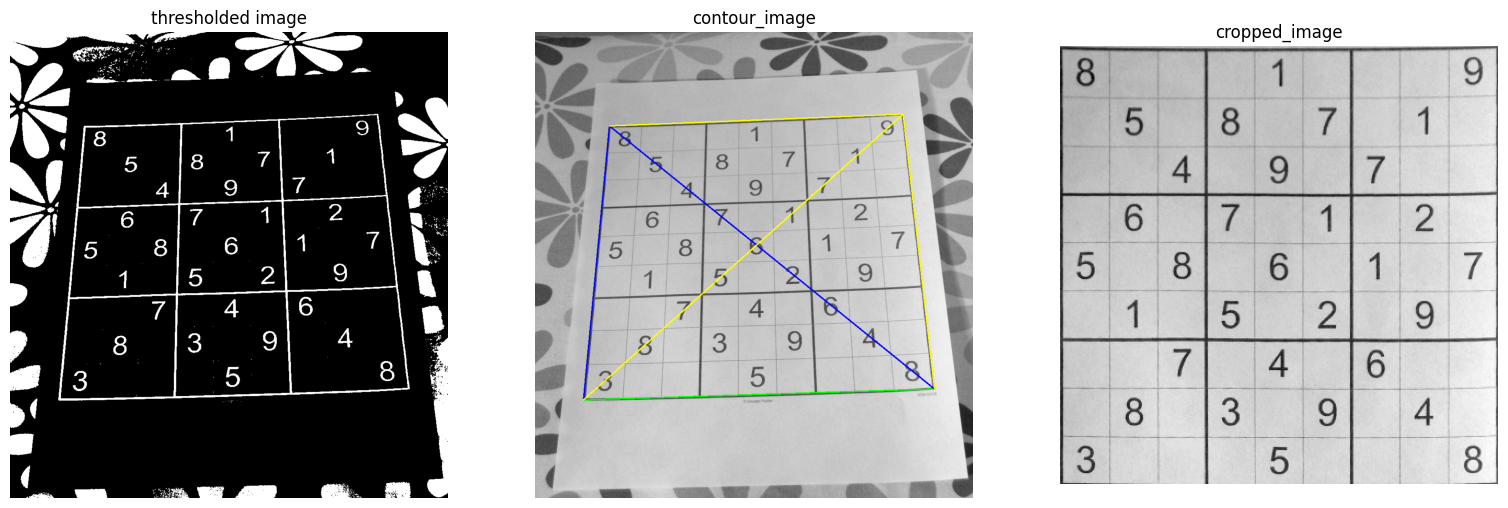

4 4 [[[1578 1093]]

 [[1718 2027]]

 [[ 264 2034]]

 [[ 276 1087]]]


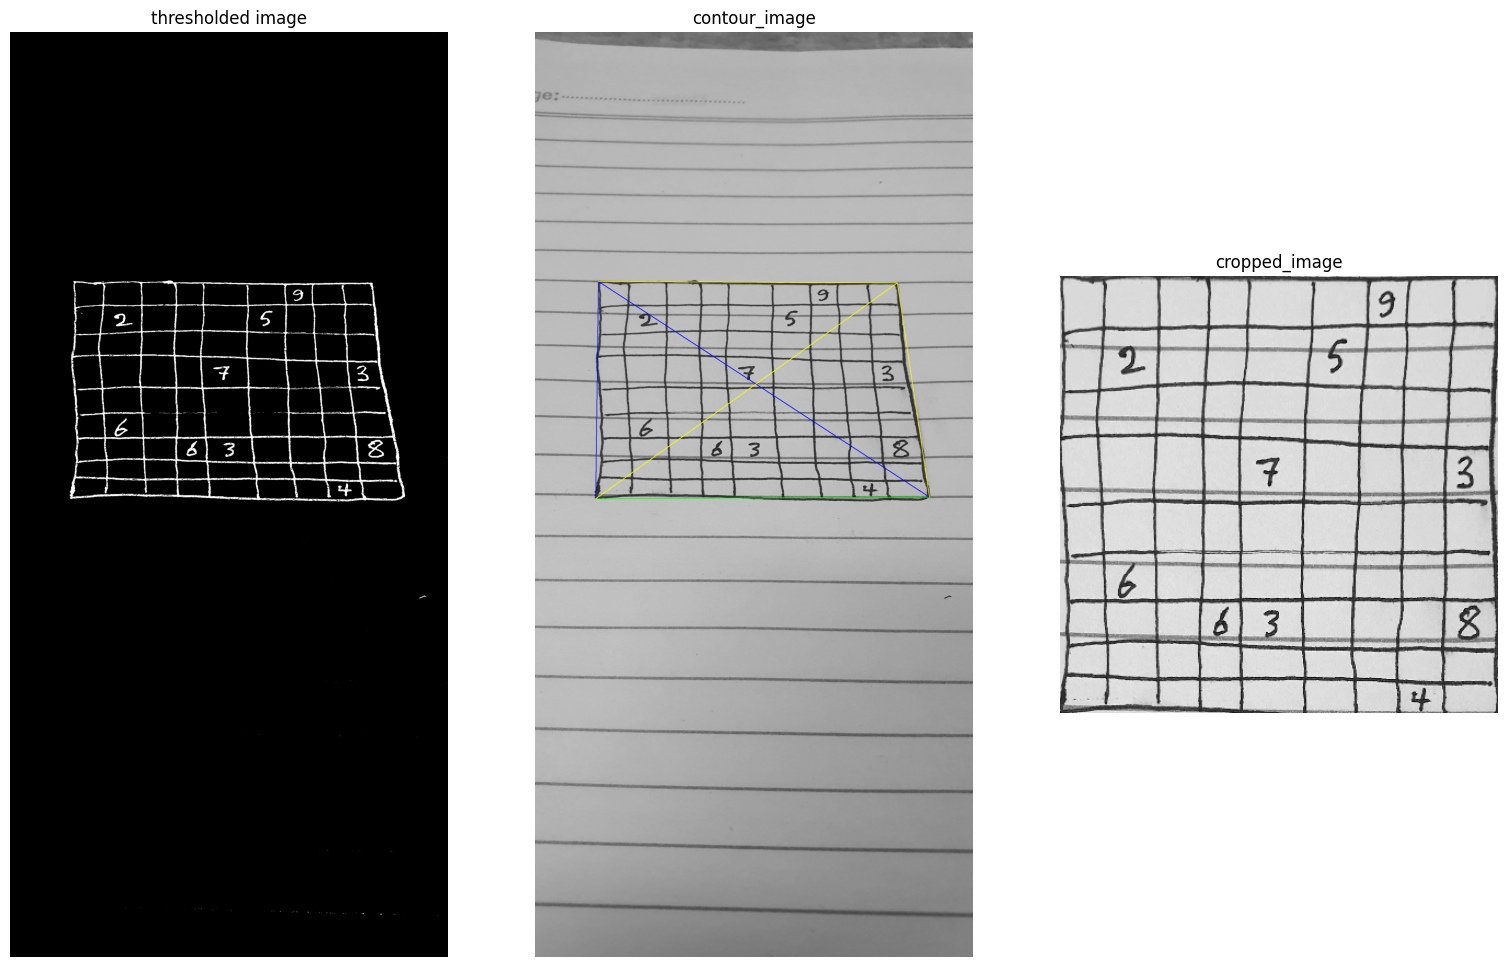

4 4 [[[855 678]]

 [[ 93 796]]

 [[ 75 192]]

 [[713  87]]]


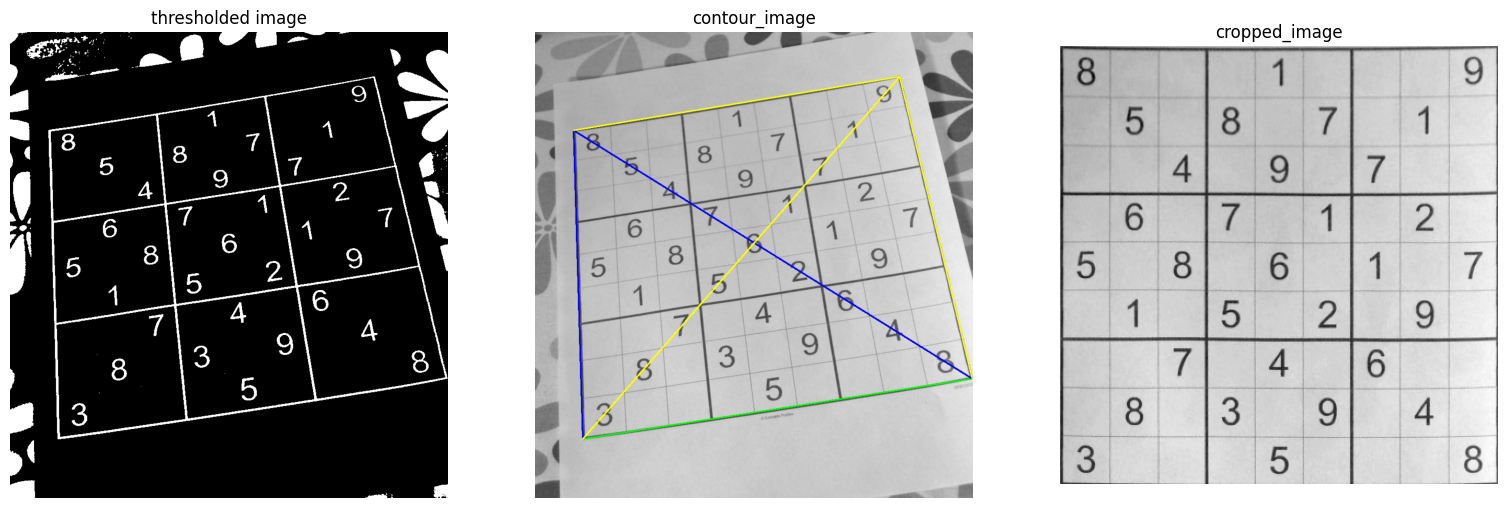

4 4 [[[961 618]]

 [[  5 650]]

 [[220 107]]

 [[744  92]]

 [[961 589]]]


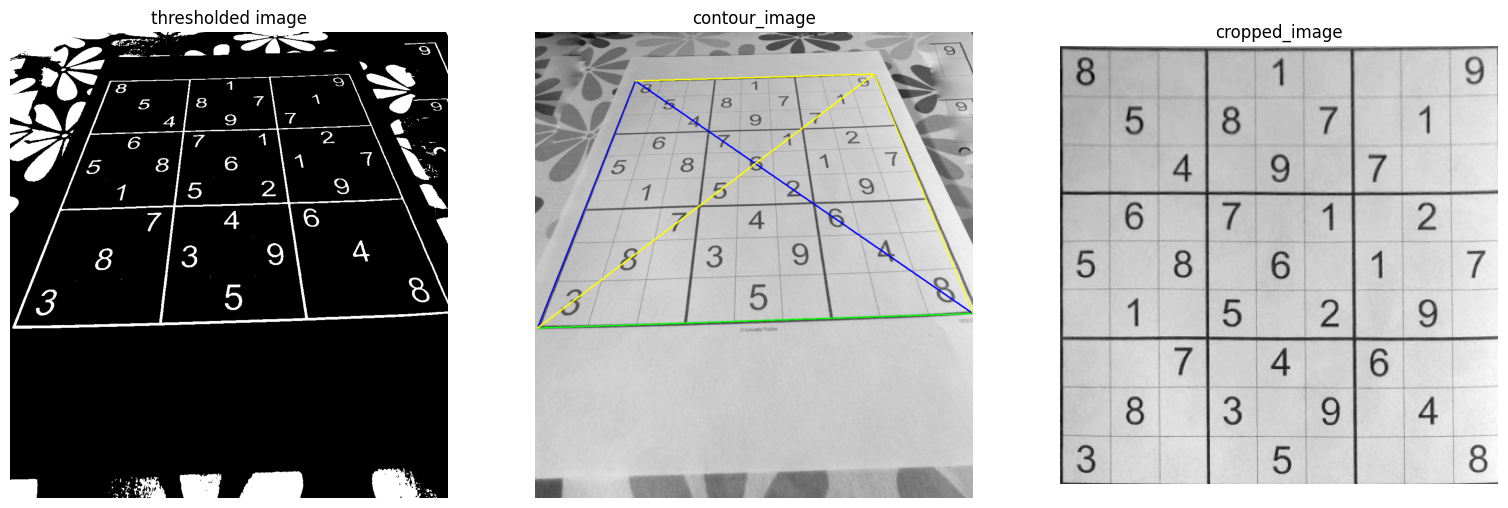

4 4 [[[876 785]]

 [[106 809]]

 [[162 206]]

 [[809 181]]]


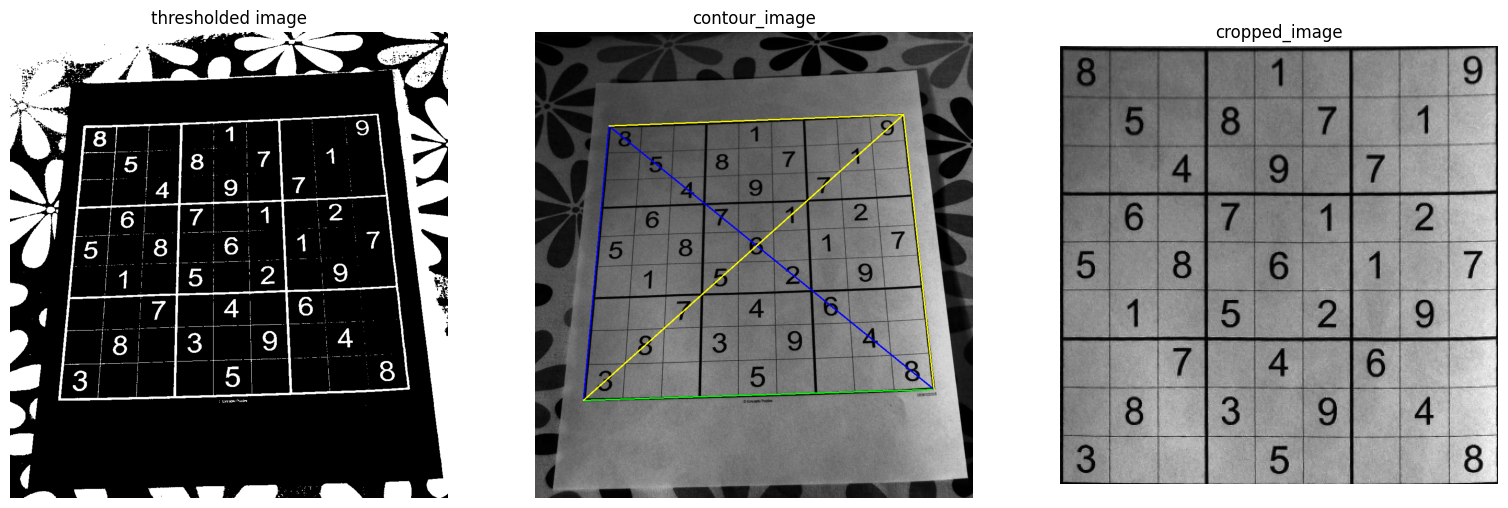

4 4 [[[763 133]]

 [[815 741]]

 [[  0 646]]

 [[  0 585]]

 [[176  79]]]


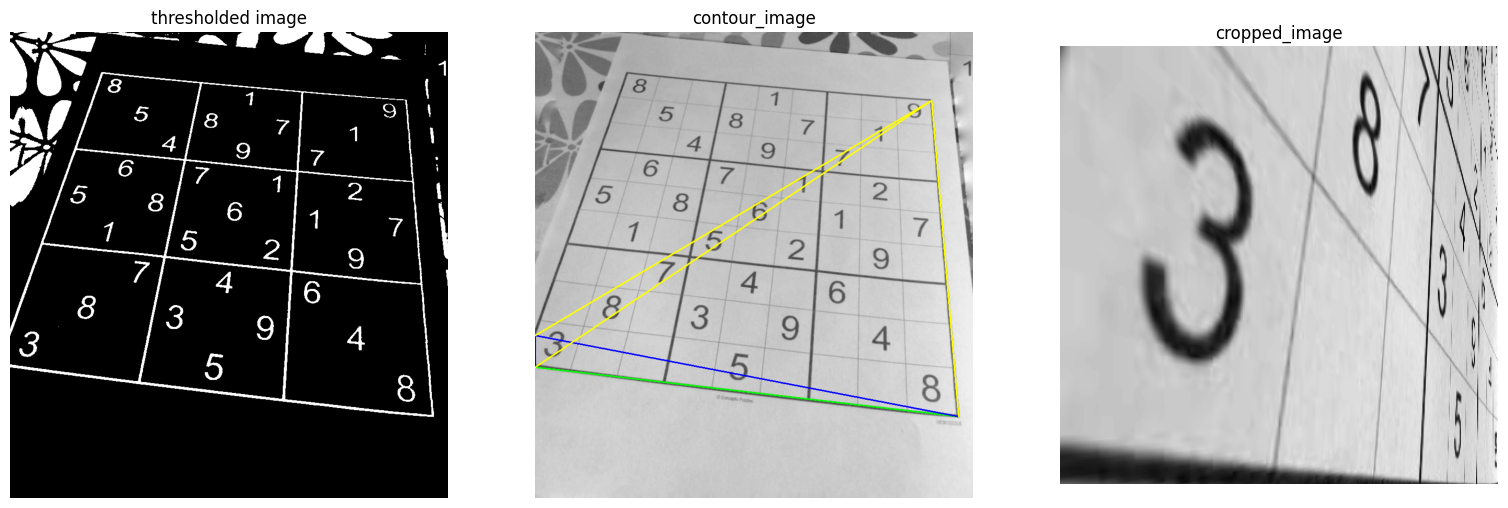

4 4 [[[872 753]]

 [[868 784]]

 [[106 808]]

 [[163 206]]

 [[808 182]]]


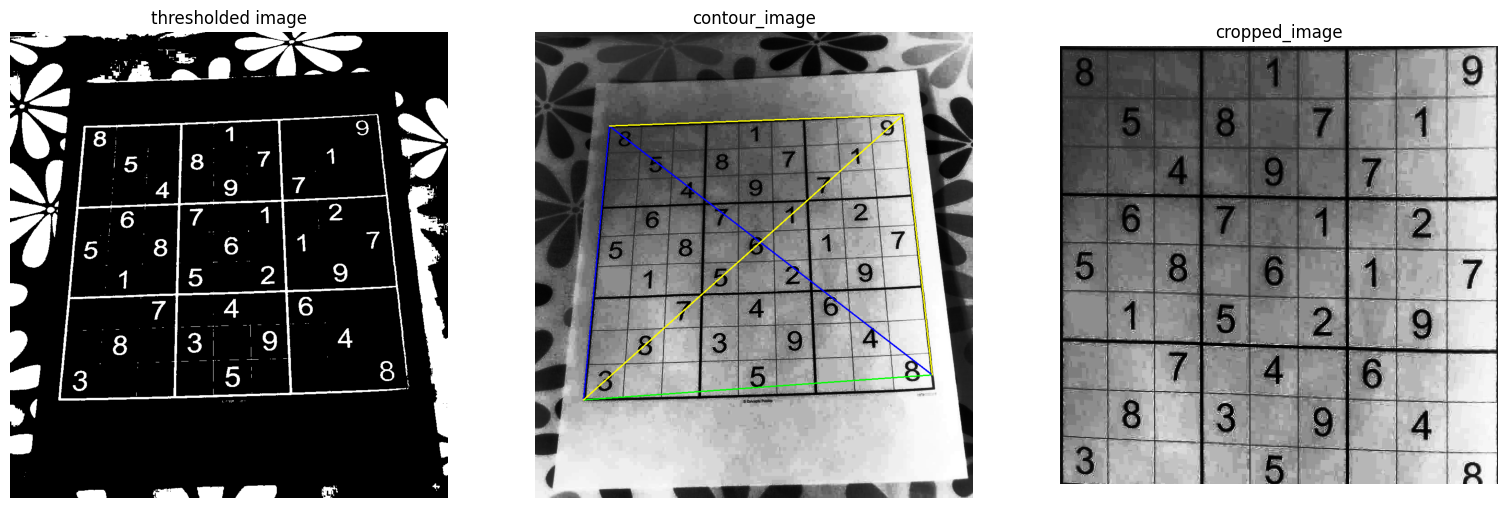

In [1636]:
files = os.listdir('./')

    # Filter only JPG files
jpg_files = [file for file in files if file.lower().endswith(".jpg")]

    # Read each JPG file
for jpg_file in jpg_files:
    file_path = os.path.join('./', jpg_file)
    doWork(file_path)